In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Data augmentation for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define normalization only for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training set with transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test set with normalization
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


In [2]:
# Define a simple CNN architecture for image classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
# Function to train a model on a dataset
def train_model(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader):.4f}")

In [4]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Train first model
model1 = SimpleCNN().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
train_model(model1, train_loader, criterion, optimizer1)

# Train second model
model2 = SimpleCNN().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
train_model(model2, train_loader, criterion, optimizer2)

# Train third model
model3 = SimpleCNN().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
train_model(model3, train_loader, criterion, optimizer3)

Epoch 1, Loss: 1.5887
Epoch 2, Loss: 1.2100
Epoch 3, Loss: 1.0351
Epoch 4, Loss: 0.9367
Epoch 5, Loss: 0.8672
Epoch 6, Loss: 0.8077
Epoch 7, Loss: 0.7725
Epoch 8, Loss: 0.7380
Epoch 9, Loss: 0.7013
Epoch 10, Loss: 0.6799
Epoch 1, Loss: 1.5701
Epoch 2, Loss: 1.1731
Epoch 3, Loss: 0.9966
Epoch 4, Loss: 0.8776
Epoch 5, Loss: 0.8085
Epoch 6, Loss: 0.7579
Epoch 7, Loss: 0.7125
Epoch 8, Loss: 0.6795
Epoch 9, Loss: 0.6491
Epoch 10, Loss: 0.6286
Epoch 1, Loss: 1.5833
Epoch 2, Loss: 1.1960
Epoch 3, Loss: 1.0062
Epoch 4, Loss: 0.8983
Epoch 5, Loss: 0.8296
Epoch 6, Loss: 0.7741
Epoch 7, Loss: 0.7346
Epoch 8, Loss: 0.7044
Epoch 9, Loss: 0.6775
Epoch 10, Loss: 0.6450


In [8]:
# Function to evaluate an ensemble of models using majority voting
def evaluate_ensemble(models, loader):
    correct, total = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = [model(inputs).detach() for model in models]
        preds = [torch.argmax(o, dim=1) for o in outputs]
        stacked = torch.stack(preds)
        voted = torch.mode(stacked, dim=0).values
        correct += (voted == labels).sum().item()
        total += labels.size(0)
    print(f"Ensemble Accuracy: {100 * correct / total:.2f}%")

evaluate_ensemble([model1, model2, model3], test_loader)

Ensemble Accuracy: 80.46%


In [9]:
import matplotlib.pyplot as plt
import torchvision.utils
from torchsummary import summary

In [10]:
# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
# Show one image for each class
def show_10_class_examples(loader):
    shown_classes = set()
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()
    i = 0
    for images, labels in loader:
        for img, label in zip(images, labels):
            class_name = classes[label.item()]
            if class_name not in shown_classes:
                img = img * 0.5 + 0.5  # unnormalize
                npimg = img.numpy().transpose((1, 2, 0))
                axes[i].imshow(npimg)
                axes[i].set_title(class_name)
                axes[i].axis('off')
                shown_classes.add(class_name)
                i += 1
            if len(shown_classes) == 10:
                plt.tight_layout()
                plt.show()
                return

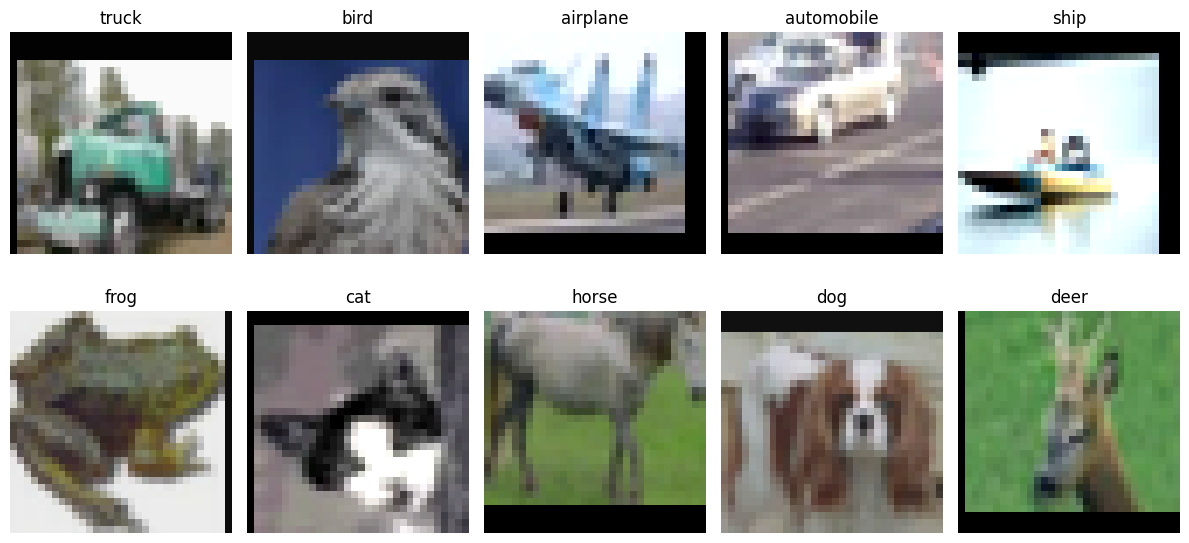

In [12]:
# Call the function to show images from train_loader
show_10_class_examples(train_loader)

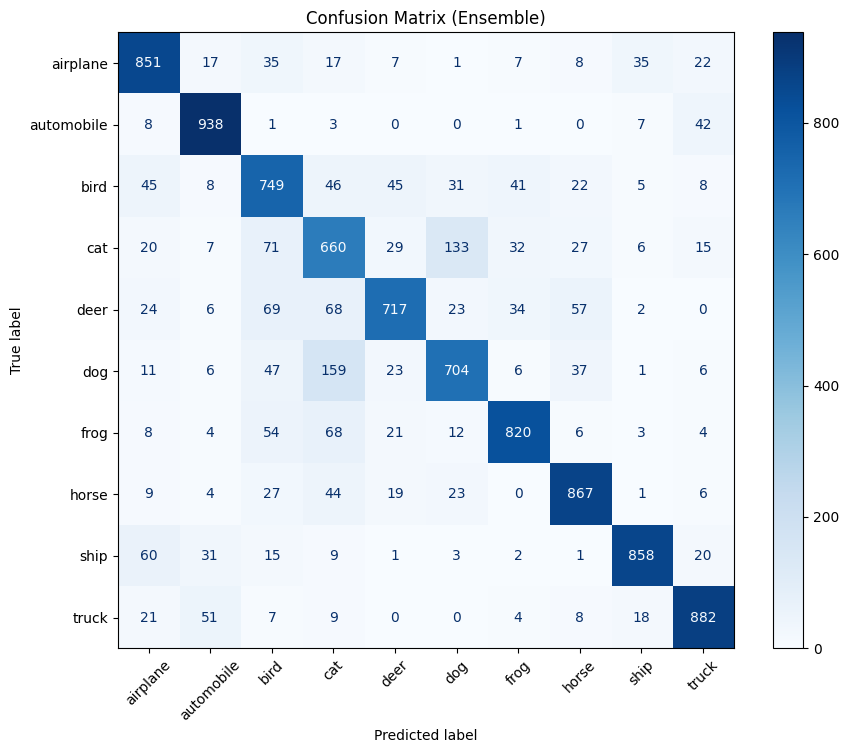

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_ensemble_confusion_matrix(models, loader, class_names):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = [model(inputs) for model in models]
            preds = [torch.argmax(o, dim=1) for o in outputs]
            stacked = torch.stack(preds)
            voted = torch.mode(stacked, dim=0).values
            all_preds.extend(voted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute and display the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix (Ensemble)")
    plt.show()

# Call the function
plot_ensemble_confusion_matrix([model1, model2, model3], test_loader, classes)